# Predicting Heart Disease

The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future. 

In [1]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
heart_df = pd.read_csv(r"C:\Users\danca\Downloads\heart_train.csv")
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat,1
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1


In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 68.9+ KB


In [4]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.848774,132.874659,203.227520,0.228883,136.377384,0.865123,0.553134
std,9.440574,18.080330,108.402067,0.420400,25.832297,1.056964,0.497508
min,29.000000,92.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,180.000000,0.000000,119.000000,0.000000,0.000000
50%,55.000000,130.000000,225.000000,0.000000,138.000000,0.500000,1.000000
75%,61.000000,141.000000,269.750000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


From the table above, we can observe that:

- The average age of patients is ~`53` years.
- The median for `Cholesterol` is higher than its mean by roughly `25` mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

`RestingBP` can't be `0`. And, as per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be `0` as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [5]:
heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

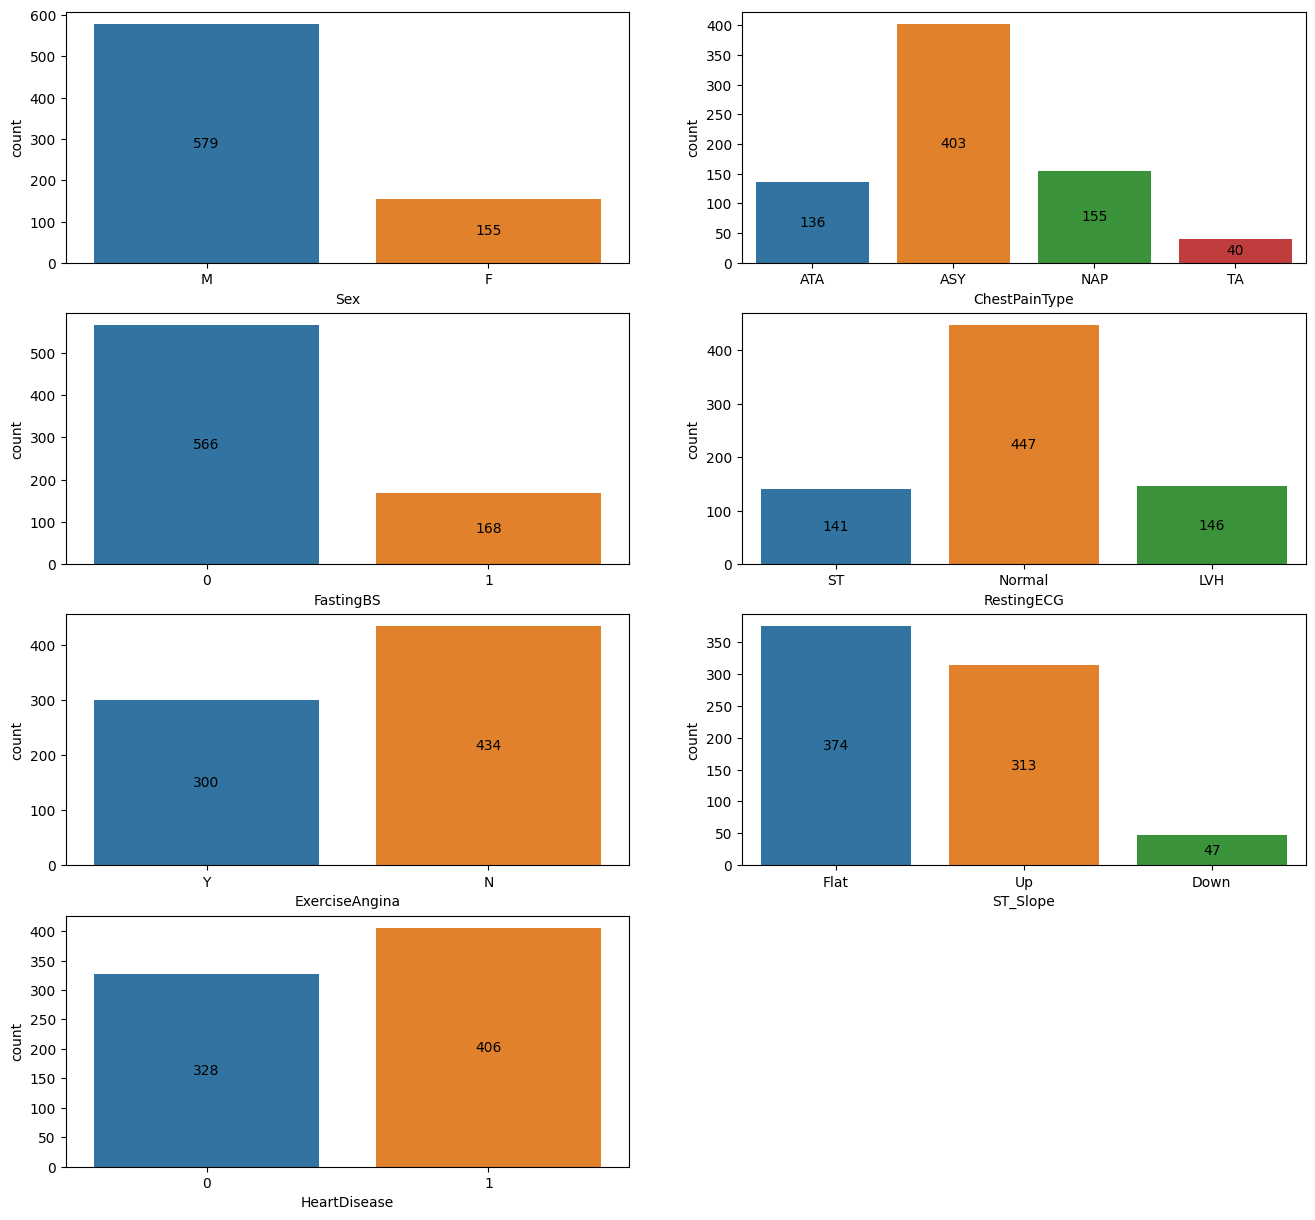

In [6]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=heart_df[col], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- The dataset is highly skewed towards male patients. There are `725` male patients and `193` female patients. This could potentially induce a bias in our model.
- `496` patients had `ASY` (asymptotic) chest pain type.
- `552` patients had a normal restin ECG.
- `704` patients had blood sugar lower than `120` mg/dl

Grouping these by `HeartDisease` will give us a better idea about the data distribution.

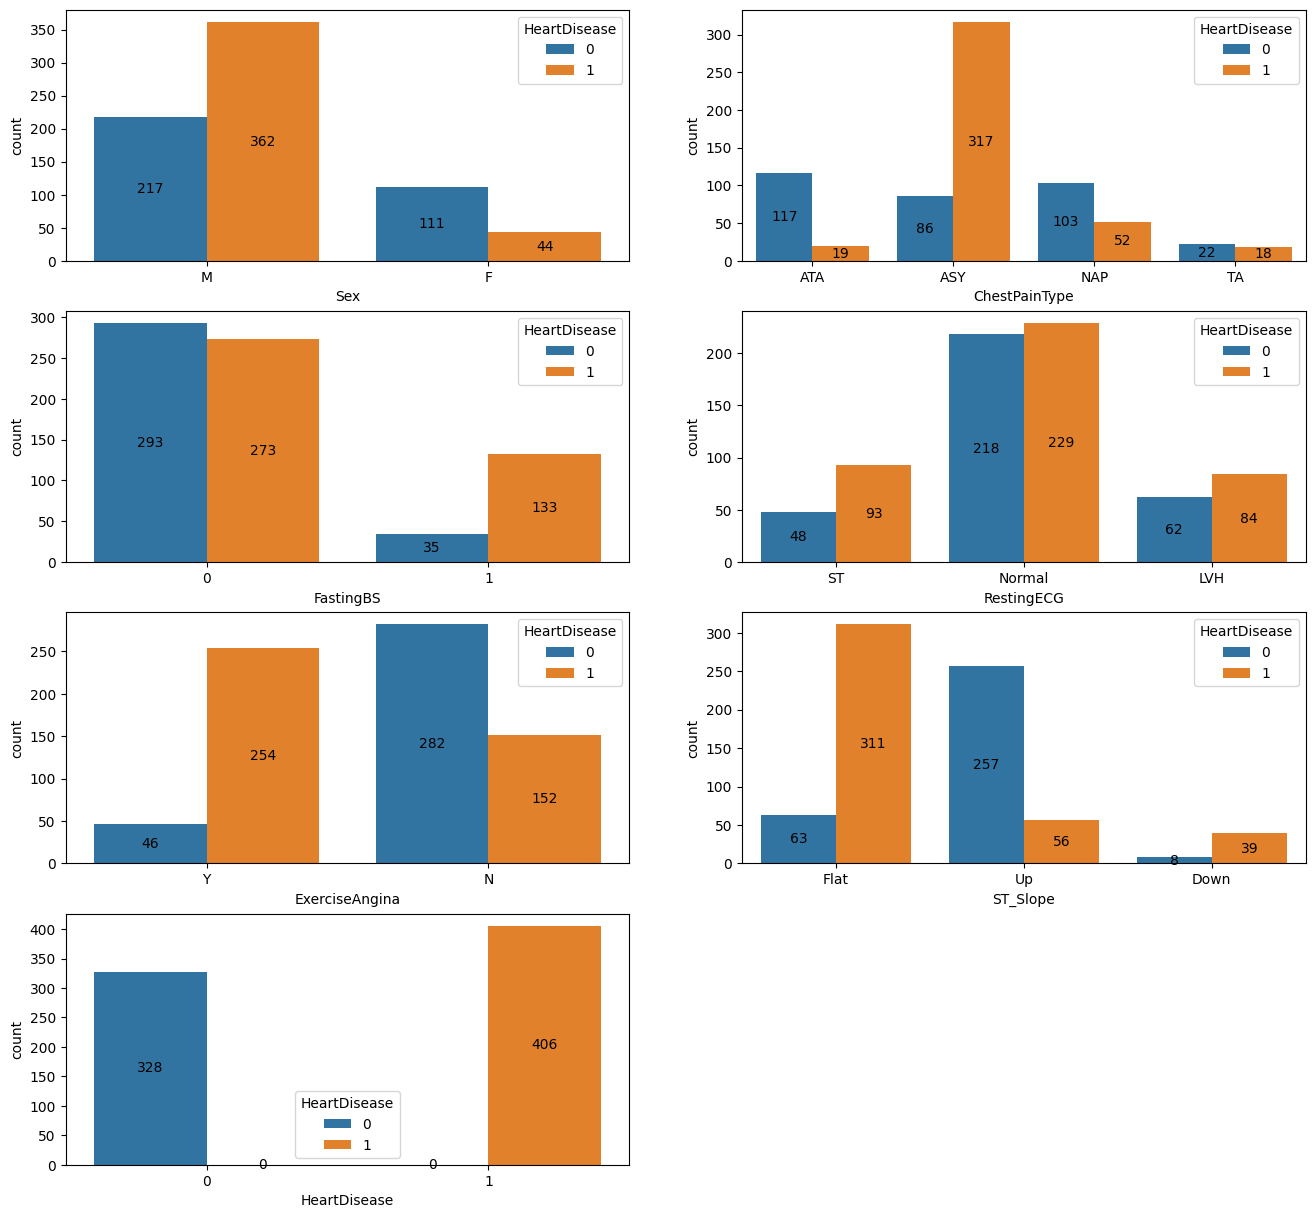

In [7]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, idx+1)
    #grouping by heart disease
    sns.countplot(x=heart_df[col],hue=heart_df['HeartDisease'], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom. 
- A high number (`170`) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, `316` were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, `381` were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

In [8]:
heart_df[heart_df['RestingBP']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             0 non-null      int64  
 1   Sex             0 non-null      object 
 2   ChestPainType   0 non-null      object 
 3   RestingBP       0 non-null      int64  
 4   Cholesterol     0 non-null      int64  
 5   FastingBS       0 non-null      int64  
 6   RestingECG      0 non-null      object 
 7   MaxHR           0 non-null      int64  
 8   ExerciseAngina  0 non-null      object 
 9   Oldpeak         0 non-null      float64
 10  ST_Slope        0 non-null      object 
 11  HeartDisease    0 non-null      int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 0.0+ bytes


In [9]:
heart_df[heart_df['Cholesterol']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 3 to 721
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             129 non-null    int64  
 1   Sex             129 non-null    object 
 2   ChestPainType   129 non-null    object 
 3   RestingBP       129 non-null    int64  
 4   Cholesterol     129 non-null    int64  
 5   FastingBS       129 non-null    int64  
 6   RestingECG      129 non-null    object 
 7   MaxHR           129 non-null    int64  
 8   ExerciseAngina  129 non-null    object 
 9   Oldpeak         129 non-null    float64
 10  ST_Slope        129 non-null    object 
 11  HeartDisease    129 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 13.1+ KB


`RestingBP` has only none zero value. We can remove that row from consideration. There are `129` zero values for `Cholesterol`. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in  `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [14]:
df_clean = heart_df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean.loc[~heartdisease_mask, "Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [16]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,734.000000,734.000000
mean,241.911444,132.874659
std,55.099925,18.080330
min,85.000000,92.000000
25%,215.000000,120.000000
50%,228.000000,130.000000
75%,269.750000,141.000000
max,603.000000,200.000000


In [18]:
df_clean['ChestPainType'].value_counts()

ASY    403
NAP    155
ATA    136
TA      40
Name: ChestPainType, dtype: int64

## Feature Selection

Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`


We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.